# *Lecture 14*

# Multidimensional Monte Carlo Methods

### Introduction

In previous lectures, we introduced Monte Carlo methods for functions that were all 1-dimensional, just to introduce the methods.

Now we will extend the methods to multiple dimensions and investigate the resulting behavior.

Remember: these Monte Carlo methods accomplish two purposes:
* numerically integrate a function without recourse to analytic expansions like the trapezoid rule, Simpson's rule
* simulate physical states contributing to the integration

## Electromagnetic Physics Application

Electric charge is distributed over a capacitor plate with its edge at $x^2 + y^2 = 1$ so that its charge density is $\sigma(x,y) = 1 + x^2 + y^2 \ \text{C/m}^2$.  What is the total charge on the plate?

## Multidimensional integration
When we perform a multidimensional integration, the relative error in the
Monte Carlo technique, being statistical, decreases as $1/\sqrt{N}$.

$$\sigma_\text{MC} = \frac{1}{\sqrt{N}}$$

This is valid
even if the $N$ points are distributed over $D$ dimensions.  (It seems like a trick that is too good to be true, but it is actually true, because the average of the function over the hyper-volume still has an error governed by the central limit theorem. 

In contrast, when
we use these same $N$ points to perform a $D$-dimensional integration as $d$
separate 1-D integrals using a rule such as the trapezoid rule, we use $\sqrt[d]N$ points for
each integration. For fixed $N$, this means that the number of points used for
the integration in each dimension decreases as the number of dimensions $d$ increases, and so
the error in each integration *increases* with $d$. 

$$\sigma_i \sim \frac{1}{N^{2/d}}$$

If you put these
trends together and do the analysis for the trapezoid integration rule, you will find
that at a value of $D \simeq 3$ or $ 4$ the error in Monte Carlo integration is
approximately equal to that of conventional schemes. For larger values of $D$,
the Monte Carlo method is always more accurate!

### Multidimensional Example

Let us test these ideas with a known 2-dimensional integral:

$$\int_0^\pi \int_0^\pi g(x,y) \,dx\,dy = \int_0^\pi \int_0^\pi \sin(x) \sin(y) \,dx \,dy$$

What follows is not the most efficient Python implementation, but it is more clear than a method for an arbitrary $d$.

For this example, the 2-D plane is sliced into 1-D slices, and then the trapezoid rule is applied to each 1-D slice in turn.
This is tantamount to approximating the function in each 2-D pixel as a 0th order polynomial in the first dimension and a 1st-order polynomial in the second dimension.

In [1]:
import numpy as np
import random

def f(x):
    return np.sin(x)

def wTrap(i, h, N):                # Total weight definition function
    if ( (i == 1) or (i == N) ):
        wTotal = h/2.0
    else:
        wTotal = h
    return wTotal

def integration_trapezoid(f, a, b, N):
    h = (b - a)/(N - 1)
    sum = 0.
    for i in range(1, N + 1):
        t = a + (i - 1)*h
        this_term = wTrap(i, h, N) * f(t)
        sum  += this_term
    result = sum
    error = abs(result - 2.000)
    return (result, error)

def integration_MC(f, a, b, N):
    sum = 0.
    sum2 = 0.
    for i in range(N):
        x = random.uniform(a, b)
        sum += f(x)
        sum2 += pow(f(x),2)
    result = (b - a) * sum/N
    sigma = np.sqrt((sum2/N - pow(sum/N,2))/N)
    error = abs(result - 2.000)
    return (result, error)

In [2]:
from scipy.stats import qmc
def g(x,y):
    return np.sin(x)*np.sin(y)

# integrate over intervals [a1, b1] and [a2, b2]
def integration_trapezoid_2d(g, a1, b1, a2, b2, N):
    N1 = int(np.sqrt(N))
    N2 = int(np.sqrt(N))
    h1 = (b1 - a1)/(N1 - 1)
    h2 = (b2 - a2)/(N2 - 1)
    sum = 0.
    for i1 in range(1, N1 + 1):
        x = a1 + (i1 - 1)*h1
        for i2 in range(1, N2 + 1):
            y = a2 + (i2 - 1)*h2
            this_term = wTrap(i1, h1, N1) * wTrap(i2, h2, N2) * g(x,y)
            sum += this_term
    result = sum
    error = abs(result - 4.000)
    return (result, error)

def integration_MC_2d(g, a1, b1, a2, b2, N):
    sum = 0.
    for i in range(N):
        x = random.uniform(a1, b1)
        y = random.uniform(a2, b2)
        sum += g(x,y)
    result = (b2 - a2) * (b1 - a1) * sum/N
    error = abs(result - 4.000)
    return (result, error)

def integration_qMC_2d(g, a1, b1, a2, b2, N):
    sum = 0.
    halton_sampler = qmc.Halton(d=2, scramble=True)
    x_halton = halton_sampler.random(N) # on interval [0,1]
    for i in range(N):
        x = x_halton[i,0]*(b1-a1) + a1
        y = x_halton[i,1]*(b2-a2) + a2
        sum += g(x, y)
    result = (b2 - a2) * (b1 - a1) * sum/N
    error = abs(result - 4.000)
    return (result, error)

Notice that there is a change in the trapezoid "weights" here.
Since the weight was calculated only for one dimension (and that weight is basically $h_2$ or $h_2/2$), we need to account for the width of the trapezoid in the second dimension.  This is the fixed value $h_1$ (or $h_1/2$ at the ends).

Another way to do this would have been to derive a new "trapezoid" rule that approximates the function as a linear function in both dimensions, instead of linear in one and constant in the other.  I invite you to try this as an experiment.

Let's see how we do with this simple version.  Which method wins the race?

In [3]:
for N in np.logspace(1, 5, num=5, dtype=int):
    print("N =", N)
    print("Trap:", integration_trapezoid_2d(g, 0, np.pi, 0, np.pi, N))
    print("  MC:", integration_MC_2d(g, 0, np.pi, 0, np.pi, N))
    print(" qMC:", integration_qMC_2d(g, 0, np.pi, 0, np.pi, N))

N = 10
Trap: (2.4674011002723395, 1.5325988997276605)
  MC: (3.709544874413397, 0.290455125586603)
 qMC: (3.6490885677391347, 0.3509114322608653)
N = 100
Trap: (3.919017334350082, 0.08098266564991796)
  MC: (4.132567272033134, 0.13256727203313368)
 qMC: (3.9595326280291228, 0.04046737197087724)
N = 1000
Trap: (3.992691187099939, 0.007308812900061135)
  MC: (3.8701292966686673, 0.12987070333133266)
 qMC: (3.9951911291050237, 0.00480887089497628)
N = 10000
Trap: (3.9993286837449227, 0.0006713162550773255)
  MC: (4.038587627624819, 0.038587627624819376)
 qMC: (3.999839817268074, 0.00016018273192619503)
N = 100000
Trap: (3.999933688889808, 6.631111019217428e-05)
  MC: (4.0059037848844365, 0.005903784884436547)
 qMC: (4.0000469963883765, 4.699638837646347e-05)


The qMC results and the Trap results scale the same with $N$, approximately $1/N$, but it's interesting that the qMC is always slightly better.

Let's hear it for quasi-Monte Carlo!

### Another Example (3-D)

$$\int_{-1}^1 \int_{-1}^1 \int_{-1}^1 \left(x^2 + y^2 + z^2 \right)  \,dx \,dy \,dz$$

What is the exact answer?

In [4]:
def m(x):
    # x is a vector of dimension d
    sum = 0.
    for xi in x:
        sum += (xi * xi)
    return sum

def integration_MC_d(m, d, a, b, N):
    # m is integrand
    # d is number of dimensions (must match function)
    # a and b are limits of integration
    # N is number of points to use in Monte Carlo method
    sum = 0.
    x = np.zeros(d)
    for i in range(N):
        for id in range(d):
            x[id] = random.uniform(a[id], b[id])
        sum += m(x)
    volume = 1.
    for id in range(d):
        volume *= (b[id] - a[id])
    result = volume * sum/N
    error = abs(result - 8.)
    return (result, error)

for N in np.logspace(1, 6, num=6, dtype=int):
    print("N =", N)
    print("MC: ", integration_MC_d(m, 3, np.array([-1.,-1.,-1.]), np.array([1.,1.,1.]), N))

N = 10
MC:  (9.20086853275804, 1.2008685327580402)
N = 100
MC:  (8.223151736363059, 0.22315173636305907)
N = 1000
MC:  (7.883175817965344, 0.11682418203465605)
N = 10000
MC:  (8.01930330205246, 0.019303302052460225)
N = 100000
MC:  (8.001310405272573, 0.0013104052725729787)
N = 1000000
MC:  (7.995639975804278, 0.004360024195722012)


The beautiful thing is that we can put specific constraints on the points, inside the integration itself.
Let's add a constraint. 

$$\int_{-1}^1 \int_{-1}^1 \int_{-1}^1 \left(x^2 + y^2 + z^2 \right)  \,dx \,dy \,dz, \quad \quad x^2+y^2+z^2 \leq 1$$

In [5]:
def m(x):
    # x is a vector of dimension d
    sum = 0.
    for xi in x:
        sum += (xi * xi)
    return sum
    #return 1

def integration_MC_d(m, d, a, b, N):
    # m is integrand
    # d is number of dimensions (must match function)
    # a and b are upper and lower limits of integration
    # N is number of points to use in Monte Carlo method
    sum = 0.
    x = np.zeros(d)
    for i in range(N):
        for id in range(d):
            x[id] = random.uniform(a[id], b[id])
        # Add constraint here
        # It is really a kind of weighting function.  
        # We still multiply by the entire volume, but some part of the volume 
        #  is effectively "blacked out" by this constraint.
        if pow(np.linalg.norm(x),2) <= 1.:
            sum += m(x)
    volume = 1.
    for id in range(d):
        volume *= (b[id] - a[id])
    result = volume * sum/N
    return result

print(integration_MC_d(m, 3, np.array([-1.,-1.,-1.]), np.array([1.,1.,1.]), 10000))

2.519041737201804


The answer may not be obvious, and it may be helpful to check the integration by using a constant function $m(x) = 1$ instead.
Then it is easy to compare the volumes and convince yourself that the constraint is using the count $N$ correctly.
(Why do we have some values that are not contributing to the sum but are counted in the $N$ total for $\langle m({\bf x}) \rangle$?)

Now let's calculate the charge on the plate from our initial application.  We'll change the integration code a bit so that you see $x$ and $y$ explicitly instead of a generic vector $\overrightarrow x$.

In [6]:
def charge_density(x, y):
    return 1 + pow(x,2) + pow(y,2)

def integration_MC_2d(N):
    ax = -1.
    ay = -1.
    bx = 1.
    by = 1.
    sum = 0.
    x = 0
    y = 0
    for i in range(N):
        x = random.uniform(ax, bx)
        y = random.uniform(ay, by)
        # Add constraint here
        if (pow(x,2) + pow(y,2)) <= 1.:
            sum += charge_density(x,y)
    volume = (bx-ax) * (by-ay)
    result = volume * sum/N
    return result

integration_MC_2d(1000000)

4.713041448109157

The exact answer is $3\pi/2$ Coulombs.

This technique shows the power of having access to the points used to calculate the integral.  It is the second use highlighted in today's introduction.

# Intermission


<IPython.core.display.Javascript object>


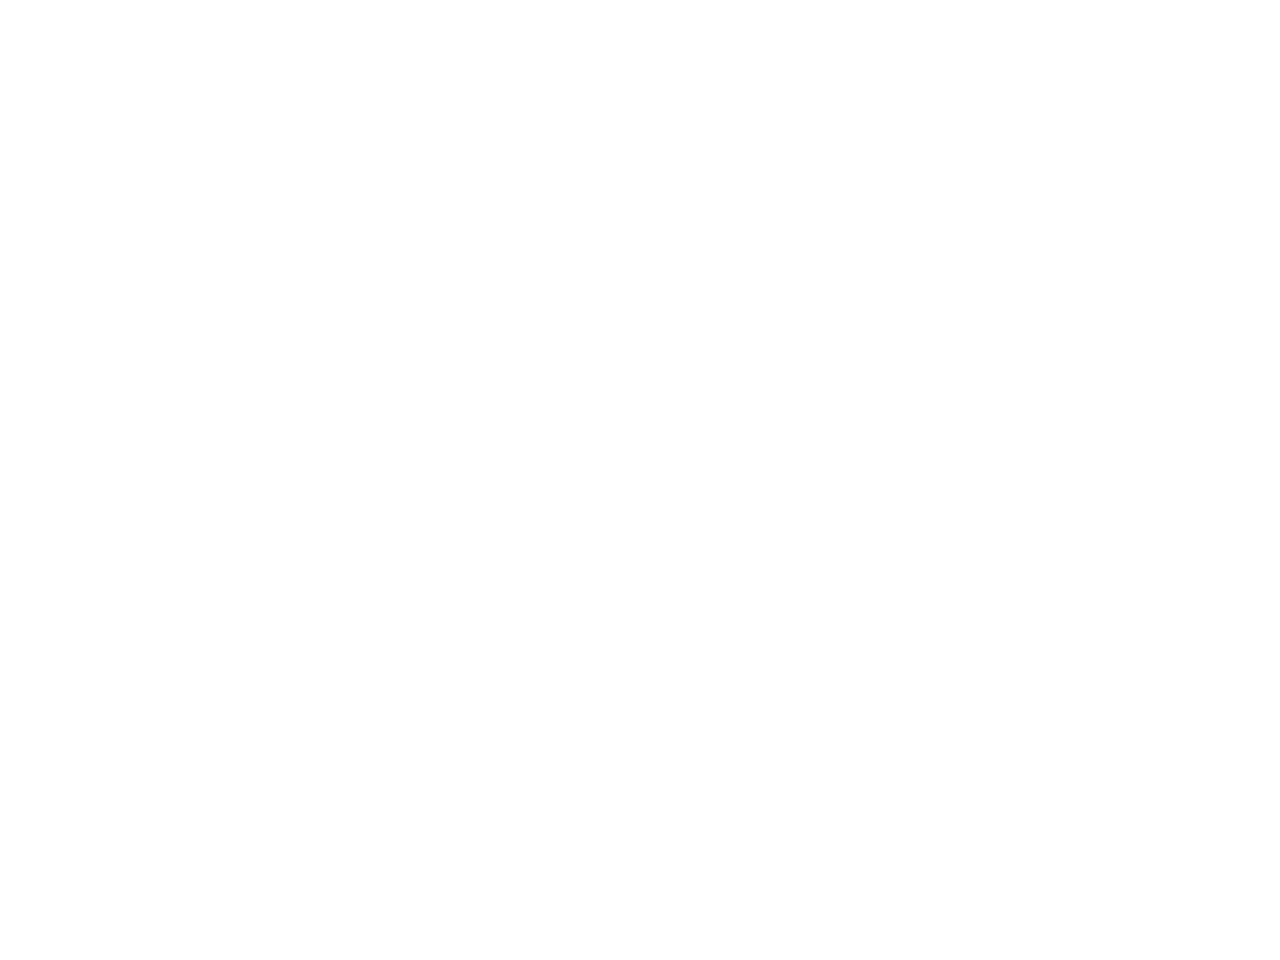

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
halton_3d_sampler = qmc.Halton(d=3, scramble=True)
x_halton = halton_3d_sampler.random(100)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(100):
    ax.scatter(x_halton[i,0], x_halton[i,1], x_halton[i,2], marker='+')
plt.show()

## Physics Example: Collider Physics

We saw a Monte Carlo method (the Metropolis algorithm) applied to statistical physics in the form of the Ising model.  Now let's see how a calculation from particle physics might use the same concepts.

* Imagine that a certain particle collider reaction $pp \rightarrow X$ has a reaction probability 
$$P = k \frac{1}{p^2}$$
so that production of high-momentum particles is naturally suppressed.  The production is isotropic in solid angle.
* Let's assume further that only particles with high transverse momentum $p_T = \sqrt{p_x^2 + p_y^2}$ can be measured in the experiment.  The $p_T$ is the key variable here because the experiment is probably a spectrometer with a large solenoid.
In this configuration, $\hat x$ points into the page and $\hat y$ points up.
<img src="Figures/CMS_Higgs.jpg" width="50%">
A typical requirement for the experiment is $p_T > 20$ (GeV).
* Finally, let's assume that the experiment can best measure particles in the "central region," with $|\tan\theta| < 2$.  (The angle $\theta$ is the "polar angle" measured with respect to the beam line or z-axis.)

What is the typical integrated total probability, and what is the measured $p_T$ distribution?

83.71755366622325


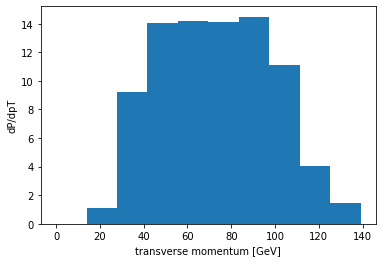

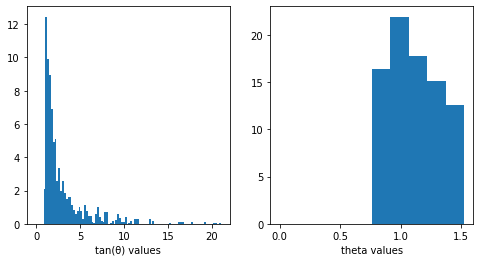

In [8]:
%matplotlib inline
import math

def probability(p):
    k = 0.1
    return pow(p,-2)
    
def particle_integration_MC_d(p, d, a, b, N):
    # m is integrand
    # d is number of dimensions (must match function)
    # a and b are limits of integration
    # N is number of points to use in Monte Carlo method
    sum = 0.
    x = np.zeros(d)
    tantheta_values = np.zeros(N)
    pt_values = np.zeros(N)
    probability_weights = np.zeros(N)
    for i in range(N):
        for id in range(d):
            x[id] = random.uniform(a[id], b[id]) # momentum components
        # Add constraint here
        pt = math.hypot(x[0],x[1])
        #print(pt, x[2])
        if pt > 20. and abs(pt/x[2]) > 1.0:
            sum += probability(np.linalg.norm(x))
            pt_values[i] = pt
            probability_weights[i] = probability(np.linalg.norm(x))
            tantheta_values[i] = pt/x[2]
    volume = 1.
    for id in range(d):
        volume *= (b[id] - a[id])
    result = volume * sum/N
    return (result, pt_values, tantheta_values, 
            volume*probability_weights/N)

(result, pt_values, tantheta_values, probability_weights) = particle_integration_MC_d(m, 3, np.array([5.,5.,5.]), np.array([100.,100.,100.]), 1000)
print(result)
plt.hist(pt_values, weights=probability_weights)
plt.xlabel('transverse momentum [GeV]')
plt.ylabel('dP/dpT')
plt.show()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(tantheta_values, weights=probability_weights, bins=100)
plt.xlabel("tan(θ) values")
plt.subplot(1,2,2)
plt.hist(np.arctan(tantheta_values), weights=probability_weights)
plt.xlabel("theta values")
plt.show()

What happens if we change the number of events $N$?
Does the total probability change?
Do the differential histograms change?

## More Physics: Variational Method in Quantum Mechanics

The **variational method** states that the expectation value of the Hamiltonian on some quantum state cannot be less than the ground state energy. (See Griffiths, Chapter 7.)
This implies that the minimum $\langle H \rangle$ over many trial states $\Psi_T$ is a good approximation to $E_0$.

$$\langle H \rangle = \frac{\int \Psi^\ast_T({\bf x; \alpha}) H({\bf x; \alpha}) \Psi_T({\bf x; \alpha})}{\int \Psi^\ast_T({\bf x; \alpha})\Psi_T({\bf x})}$$

This equation shows the explicit dependence on the coordinates ${\bf x}$ and free parameters ${\bf \alpha}$.

The variational method can take the following steps:
- Construct (guess) the trial state eigenfunction $\Psi_T ({\bf x})$, which depends on one or more variational parameters $\bf \alpha$.
- Evaluate the expectation value $\langle H \rangle$.
- Vary $\bf \alpha$ to create a new trial state $\Psi_T ({\bf x; \alpha})$

Practically speaking, the Hamiltonian is rewritten as a **local energy operator** $E_L$, used to calculate the "energy" of some trial state.

$$\begin{align}
H \Psi_T({\bf x; \alpha}) &= E_L \Psi_T({\bf x; \alpha})\\
E_L({\bf x; \alpha}) &= \frac{1}{\Psi_T({\bf x; \alpha})} H \Psi_T({\bf x; \alpha})
\end{align}$$

As with the Hamiltonian, the expectation value to be minimized is 

$$\langle E_L \rangle = \frac{\int \Psi^\ast_T({\bf x; \alpha}) E_L({\bf x; \alpha}) \Psi_T({\bf x; \alpha})}{\int \Psi^\ast_T({\bf x; \alpha})\Psi_T({\bf x})}$$

The local energy operator must be defined on a case-by-case basis from the Hamiltonian, often with knowledge of the trial state form.
We have to keep track of the changes in trial state (often accomplished with the Metropolis algorithm) without losing sight of the main goal to minimize  $\langle E_L \rangle$.

### Quantum Energies in the Harmonic Oscillator Potential

We will go through the steps for a particle in a 1-D harmonic oscillator potential.  With enlightened choices $\hbar=1$, $k=2$, and $m=1/2$, the Hamiltonian is

$$H = -\frac{d^2}{dx^2} + x^2$$

and we might choose the trial function to be 

$$\Psi_T(x) = \frac{\sqrt{\alpha}}{\pi^{1/4}} e^{-\frac{\alpha^2 x^2}{2}}$$

With these choices, the local energy operator becomes

$$
\begin{align}
E_L(x) &= \frac{1}{\Psi_T(x)} H \Psi_T(x)\\
&= e^{\frac{\alpha^2 x^2}{2}}\left[-\frac{d^2}{dx^2}\left(e^{-\frac{\alpha^2 x^2}{2}}\right) + x^2 e^{-\frac{\alpha^2 x^2}{2}}\right] \\
&= \alpha^2 + x^2 (1-\alpha^4)
\end{align}$$

And its expectation value is given after normalization:

$$
\langle E_L \rangle = \frac{\int e^{-x^2 \alpha^2} \left[\alpha^2 + x^2\left(1-\alpha^4\right) \right] dx} {\int e^{-x^2 \alpha^2} dx}
$$

We could do this integral analytically, in which case we would find

$$\langle E_L \rangle = \frac{\alpha^2}{2} + \frac{1}{2\alpha^2}$$

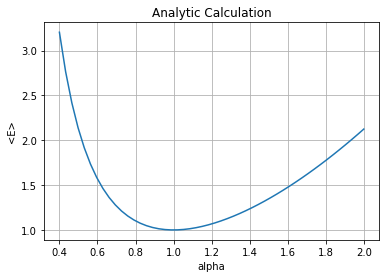

In [9]:
def el(alpha):
    # Analytic result for <E_L>
    return 0.5*pow(alpha,2) + 0.5*pow(alpha, -2)

alpha_values = np.linspace(0.4, 2.0, 50)
plt.plot(alpha_values, el(alpha_values))
plt.xlabel('alpha')
plt.ylabel('<E>')
plt.title('Analytic Calculation')
plt.grid()
plt.show()

We knew already that $\alpha=1$ gives $\Psi = e^{-x^2/2}/\pi^{1/4}$, which is the ground state of the harmonic oscillator.  And we knew that the minimum energy for these enlightened parameter choices is $E_0= (2n+1)\hbar \omega/2 = 1.0$.

But what if we need to use the Monte Carlo method to compute the integrals in the expectation value?  What are the variables of integration, and what are the fixed parameters?

In this case, $\alpha$ is our scanning variable, and we want to calculate $\langle E_L \rangle$ for each value of $\alpha$, so that we can make the plot above.

For each value of $\alpha$, we will use random $x$ values to compute the integral using the Monte Carlo method.
We can use uniform samples on $[-\infty, \infty]$, or we can use importance sampling (preferred):

$$\begin{align}
\langle E_L \rangle &= \frac{\int e^{-x^2 \alpha^2} \left[\alpha^2 + x^2\left(1-\alpha^4\right) \right] dx} {\int e^{-x^2 \alpha^2} dx}\\
&= \int P(x, \alpha) E_L(x, \alpha) dx \\
\end{align}
$$

In this version, $P(x, \alpha)$ is just the probability distribution of the $x$ values!  We can simply generate random $x$ values according to this distribution, and then evaluate the integrand $E_L$.

In fact, if you look very carefully, you will see that this distribution 
$$P(x) = e^{-x^2\alpha^2}$$
is just a Gaussian distribution.
Try different values of $\alpha$ below to see the effect.

In [10]:
def EL(x, alpha):
    return pow(alpha,2) + pow(x,2)*(1.-pow(alpha,4))

N = 10
elsum = 0.
alpha = 1.0
for i in range(N):
    x = np.random.normal(loc=0., scale=1./np.sqrt(2)/alpha)
    #print(x, EL(x,alpha))
    elsum += EL(x, alpha)
result = elsum/N
print(alpha, result)

1.0 1.0


0.4 3.0596793031344407
0.4842105263157895 2.196664005134412
0.5684210526315789 1.7776684511722687
0.6526315789473685 1.4243572313155468
0.736842105263158 1.2189031406253616
0.8210526315789474 1.0851979087852284
0.9052631578947369 1.0253680915346501
0.9894736842105263 0.9990967219046907
1.0736842105263158 1.0115664501459503
1.1578947368421053 1.0273218142305591
1.2421052631578946 1.0691507685574224
1.3263157894736843 1.171340008386599
1.4105263157894736 1.2505320660794534
1.4947368421052634 1.3761556781071664
1.5789473684210527 1.4717947455354863
1.663157894736842 1.602073127270611
1.7473684210526317 1.6467085689425325
1.831578947368421 1.8145606328578259
1.9157894736842107 1.898419071719564
2.0 2.1043320685938744


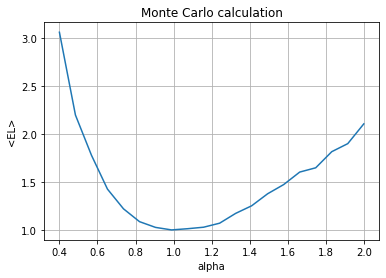

In [12]:
N = 1000
alpha_values = []
EL_exp_values = []
for alpha in np.linspace(0.4, 2.0, 20):
    elsum = 0.
    for i in range(N):
        x = np.random.normal(loc=0., scale=1./np.sqrt(2)/alpha)
        elsum += EL(x, alpha)
    result = elsum/N
    print(alpha, result)
    alpha_values.append(alpha)
    EL_exp_values.append(result)

plt.plot(alpha_values, EL_exp_values)
plt.xlabel('alpha')
plt.ylabel('<EL>')
plt.title("Monte Carlo calculation")
plt.grid()
plt.show()

The Monte Carlo calculation also tells us that the minimum value of $\langle E_L \rangle = 0$ occurs for $\alpha=1$.

It is good to see that both the variational method and the Monte Carlo method work so well on this simple example.